### Predicting which valuable employees will leave next

Why are our best and most experienced employees leaving prematurely? Predict which valuable employees will leave next. 

Fields in the dataset include:

* Employee satisfaction level
* Last evaluation
* Number of projects
* Average monthly hours
* Time spent at the company
* Whether they have had a work accident
* Whether they have had a promotion in the last 5 years
* Department
* Salary
* Whether the employee has left


#### Import Libraries

In [658]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve,auc
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [659]:
#bring in the dataset
df = pd.read_csv('HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


In [660]:
print 'Number of employees that left:',df['left'].sum()
print 'Number of employees:',df['left'].count()
print 'Percentage of employees that left:',((df['left'].sum().astype(float) / df['left'].count())*100).round(2)

Number of employees that left: 3571
Number of employees: 14999
Percentage of employees that left: 23.81


In [661]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268,0.238083
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281,0.425924
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Histograms

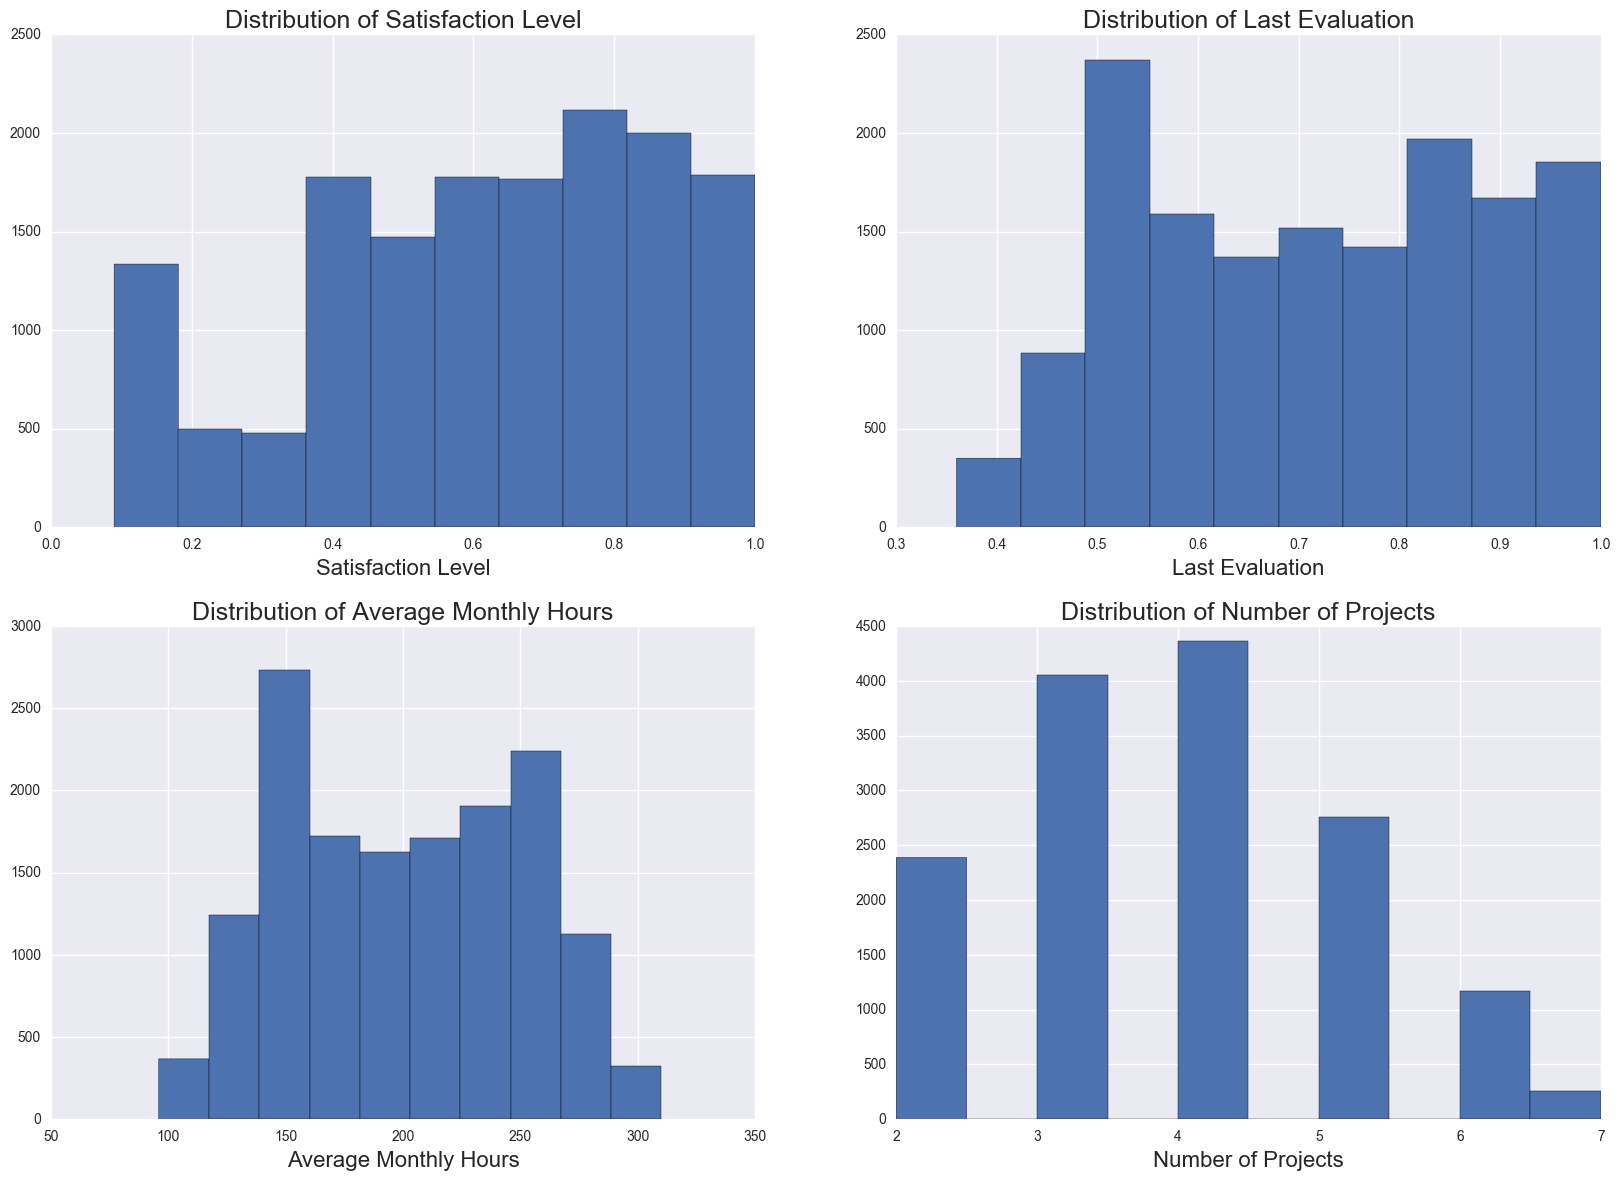

In [662]:
#satisfaction level
fig,axes = plt.subplots(2,2,figsize=(20,14))
axes[0][0].hist(x = df['satisfaction_level']) 
axes[0][0].set_title("Distribution of Satisfaction Level",fontsize = 18)
axes[0][0].set_xlabel("Satisfaction Level",fontsize = 16)
#bulk of the employees are 0.5 and higher

axes[0][1].hist(x=df['last_evaluation'])
axes[0][1].set_title('Distribution of Last Evaluation',fontsize=18)
axes[0][1].set_xlabel('Last Evaluation',fontsize=16)
#bulk of the employees are 0.5 and higher


axes[1][0].hist(x=df['average_monthly_hours']);
axes[1][0].set_title('Distribution of Average Monthly Hours',fontsize=18)
axes[1][0].set_xlabel('Average Monthly Hours',fontsize=16)
#average monthly hours is somewhat normal distribution


axes[1][1].hist(x=df['number_project'])
axes[1][1].set_title('Distribution of Number of Projects',fontsize=18)
axes[1][1].set_xlabel('Number of Projects',fontsize=16);
#number of projects is primarily 3 and 4

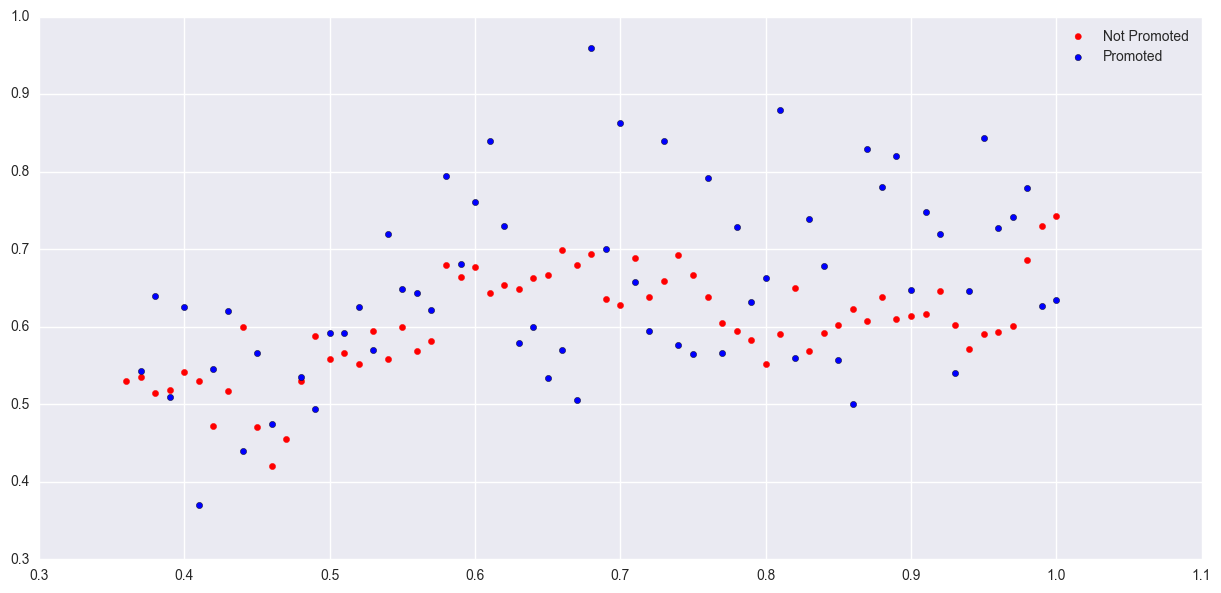

In [663]:
eval_satisfaction = df.groupby(['last_evaluation','promotion_last_5years'])['satisfaction_level'].mean().to_frame()
eval_satisfaction.reset_index(inplace = True)
eval_satisfaction
eval_satis_promoted = eval_satisfaction[eval_satisfaction['promotion_last_5years']==1]
eval_satis_notpromoted = eval_satisfaction[eval_satisfaction['promotion_last_5years']==0]
plt.subplots(figsize=(15,7))
plt.scatter(x=eval_satis_notpromoted['last_evaluation'],y=eval_satis_notpromoted['satisfaction_level'],color='red',label='Not Promoted')
plt.scatter(x=eval_satis_promoted['last_evaluation'],y=eval_satis_promoted['satisfaction_level'],label='Promoted')
plt.legend()
plt.show()

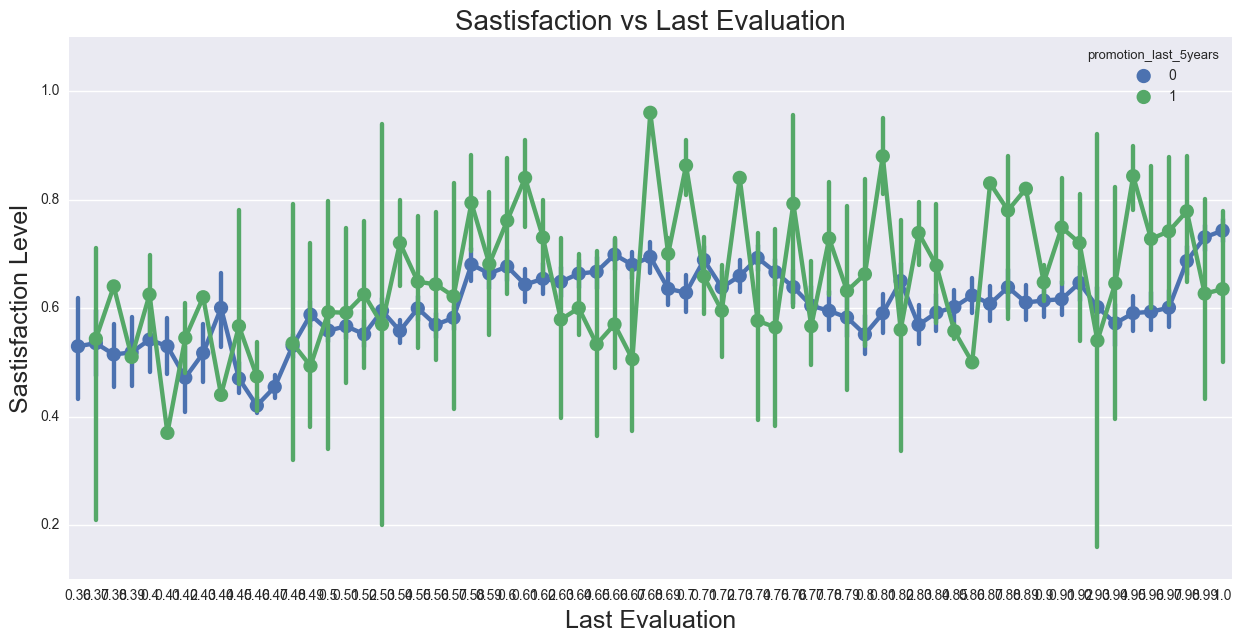

In [664]:

plt.subplots(figsize=(15,7))
sns.pointplot(data=df,x='last_evaluation',y='satisfaction_level',hue='promotion_last_5years')
plt.title('Sastisfaction vs Last Evaluation',fontsize=20)
plt.xlabel('Last Evaluation',fontsize=18)
plt.ylabel('Sastisfaction Level', fontsize = 18)
#the variance in satisfaction level for the ones that were promoted in last 5 years varies compared to ones who weren't

As the number of years increases after 3 years, the amount of employees leaving deceases.
What is so special about year 3?

   time_spend_company   len   sum
0                   2  3244    53
1                   3  6443  1586
2                   4  2557   890
3                   5  1473   833
4                   6   718   209
5                   7   188     0


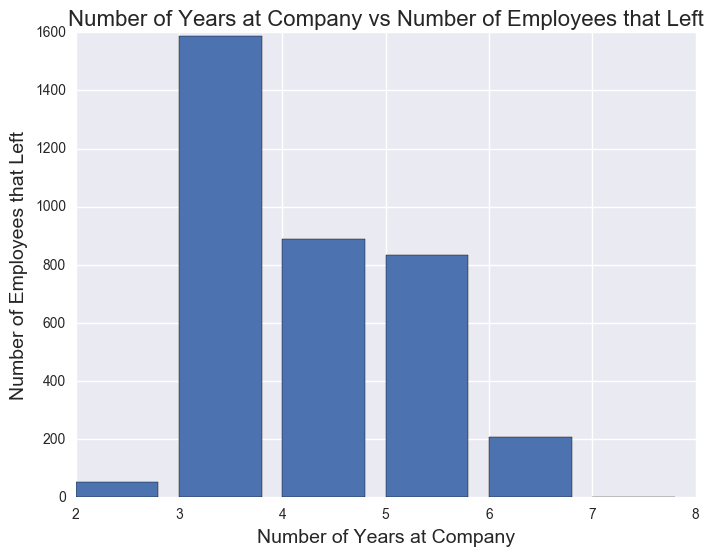

In [665]:
time = df.groupby(['time_spend_company'])['left'].agg([len,sum])
time.reset_index(inplace = True)
time = time[:6]
print time
plt.subplots(figsize=(8,6))
plt.bar(left=time['time_spend_company'],height=time['sum'])
plt.title('Number of Years at Company vs Number of Employees that Left',fontsize=16)
plt.xlabel('Number of Years at Company',fontsize=14)
plt.ylabel('Number of Employees that Left',fontsize=14);
#plt.xticks(9,[2,3,4,5,6,7,8,9,10,11],)

In [666]:
projects = df[(df['time_spend_company']>=3) & (df['time_spend_company']<=5) ].groupby('number_project')['left'].agg([len,sum])
projects['diff'] = (projects['sum'] / projects['len']).round(2)
projects
#most employees leave year 3-5 and only have 2 projects. People who have been there for 3 years and have 7 project all left.

,len,sum,diff
number_project,,,
2,2073,1560,0.75
3,2447,55,0.02
4,2820,309,0.11
5,1889,489,0.26
6,989,641,0.65
7,255,255,1.00


In [667]:
df[(df['time_spend_company']>=3) & (df['time_spend_company']<=5) & (df['number_project']==2)].describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,2073.000000,2073.000000,2073.0,2073.000000,2073.000000,2073.00000,2073.000000,2073.000000
mean,0.460111,0.556440,2.0,156.113845,3.145683,0.07670,0.010130,0.752533
std,0.143927,0.123713,0.0,34.718832,0.452366,0.26618,0.100162,0.431645
min,0.100000,0.360000,2.0,98.000000,3.000000,0.00000,0.000000,0.000000
25%,0.380000,0.480000,2.0,136.000000,3.000000,0.00000,0.000000,1.000000
50%,0.420000,0.520000,2.0,147.000000,3.000000,0.00000,0.000000,1.000000
75%,0.450000,0.560000,2.0,158.000000,3.000000,0.00000,0.000000,1.000000
max,1.000000,1.000000,2.0,310.000000,5.000000,1.00000,1.000000,1.000000


Average Monthly Hours of employees who have had 3 years at the company and 2 projects:
count    3309.000000
mean      205.165911
std        62.274769
min       126.000000
25%       145.000000
50%       218.000000
75%       262.000000
max       310.000000
Name: average_monthly_hours, dtype: float64
IQR range: 117.0


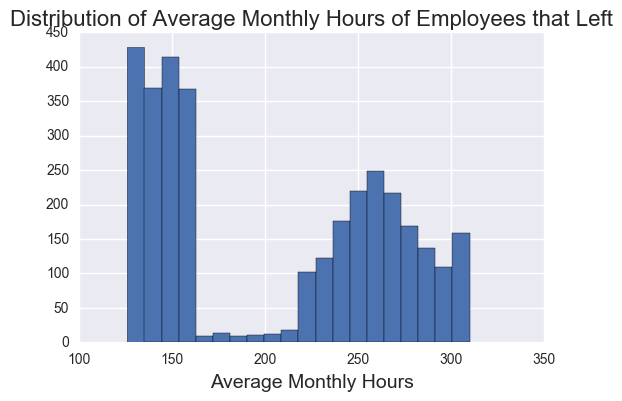

In [668]:
df[(df['time_spend_company']>=3) & (df['time_spend_company']<=5)].groupby(['average_monthly_hours'])['left'].agg([len,sum])
print 'Average Monthly Hours of employees who have had 3 years at the company and 2 projects:'
print df[(df['time_spend_company']>=3) & (df['time_spend_company']<=5) & (df['left']==1)]['average_monthly_hours'].describe()
df[(df['time_spend_company']>=3) & (df['time_spend_company']<=5) & (df['left']==1)]['average_monthly_hours'].hist(bins=20)
plt.title('Distribution of Average Monthly Hours of Employees that Left',fontsize=16)
plt.xlabel('Average Monthly Hours',fontsize=14)
p25 = df[(df['time_spend_company']>=3) & (df['time_spend_company']<=5) & (df['left']==1)]['average_monthly_hours'].quantile(q=.25)
p75 = df[(df['time_spend_company']>=3) & (df['time_spend_company']<=5) & (df['left']==1)]['average_monthly_hours'].quantile(q=.75)
print 'IQR range:',p75 - p25

#if an average of 4 weeks per month and 40 hours per week, that would be about 160 hours per week
#see two clusters, one that worked less than 160 hours (part time hours) and those that worked more than 40 hrs/wk

In [669]:
#distribution for salary all/high/medium/low

In [670]:
#among the employees that have been with the company 3 years and 2 projects, most of them worked less than 200 hours.
yrs3_proj2 = df[(df['time_spend_company']==3) & (df['number_project']==2)].copy()
yrs3_proj2['hours_bucket'] = yrs3_proj2['average_monthly_hours'].apply(lambda x: 1 if x > 155 else 0)
yrs3_proj2.groupby('hours_bucket')['left'].agg([len,sum])

,len,sum
hours_bucket,,
0,1366,1266
1,488,262


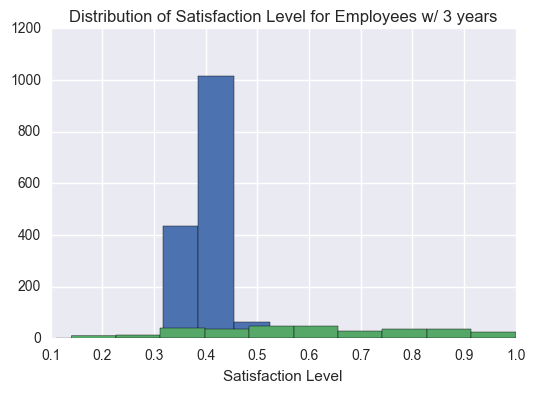

count    1528.000000
mean        0.512762
std         0.046080
min         0.450000
25%         0.480000
50%         0.510000
75%         0.540000
max         0.990000
Name: last_evaluation, dtype: float64

In [703]:
#satisfaction level is less than 45% for employees with 3 years/2 projects and that left. 
#seems reasonable that people that are less than satisfied would leave.
#for the employees that didn't leave, their satisfaction seems a bit uniform
yrs3_proj2[yrs3_proj2['left']==1]['satisfaction_level'].hist()
yrs3_proj2[yrs3_proj2['left']==0]['satisfaction_level'].hist()
plt.xlabel('Satisfaction Level')
plt.title('Distribution of Satisfaction Level for Employees w/ 3 years')
plt.show()

yrs3_proj2[yrs3_proj2['left']==1]['last_evaluation'].describe()

#75% or less have last_evaluation of .54 or less, while for the whole dataset, its .87
#given now these people have bad evaluations, we would not want them. 


In [672]:
department = df.groupby(['sales'])['left'].agg([len,sum])
department['percentage'] = (department['sum'] / department['len']).round(2)
department
#on average the percentage of people leaving is uniform across departments. management and RandD is lower.

,len,sum,percentage
sales,,,
IT,1227,273,0.22
RandD,787,121,0.15
accounting,767,204,0.27
hr,739,215,0.29
management,630,91,0.14
marketing,858,203,0.24
product_mng,902,198,0.22
sales,4140,1014,0.24
support,2229,555,0.25


On average the bulk of the people that left were there for 3 years, 2 projects and the evaluations were under 0.56.
They might have left due to poor performances, so either laid off or some other consequence such as conflict at work that resulted in low evaluation. It could be that they were not given enough work, were part-time, and thus, not enough data to give a fair evaluation.

### What makes great employees leave?

According to the data below, 25% of all employees get better than .52 on the evaluation, and 50% get 0.79 and above. Thus from earlier it could be that the poor performing employees left. Let's concentrate on 50% and better, so lets restrict the data to 0.71 (which is the mean).

In [673]:
df[df['left']==1]['last_evaluation'].describe()

count    3571.000000
mean        0.718113
std         0.197673
min         0.450000
25%         0.520000
50%         0.790000
75%         0.900000
max         1.000000
Name: last_evaluation, dtype: float64

#### Let's take a look at the mean, 0.71

In [674]:
eval_limit = 0.71
df[(df['last_evaluation']>eval_limit)].describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,7606.000000,7606.000000,7606.000000,7606.000000,7606.000000,7606.000000,7606.000000,7606.000000
mean,0.624824,0.864385,4.191559,216.385485,3.684723,0.143045,0.020116,0.248882
std,0.272608,0.081673,1.176579,47.828798,1.507638,0.350142,0.140405,0.432394
min,0.090000,0.720000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.500000,0.800000,3.000000,177.000000,3.000000,0.000000,0.000000,0.000000
50%,0.700000,0.870000,4.000000,224.000000,3.000000,0.000000,0.000000,0.000000
75%,0.830000,0.930000,5.000000,255.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [694]:
print 'Count of Stayed/Left'
print df[(df['last_evaluation']>eval_limit)]['left'].value_counts()
#need to analyze on why the employees who got a high evaluation left

salary = df[(df['last_evaluation']>eval_limit)].groupby('salary')['left'].agg([len,sum])
salary['percentage'] = (salary['sum'] / salary['len']).round(2)
salary.rename(columns={'len':'count','sum':'left'},inplace = True)
salary
#high percentage left bc of low/medium pay.



Count of Stayed/Left
0    5713
1    1893
Name: left, dtype: int64


,count,left,percentage
salary,,,
high,593,28,0.05
low,3728,1143,0.31
medium,3285,722,0.22


Employees that left shows a positively skewed distributed of average monthly hours meaning they tend to work alot more than 160 hours (assuming 40 hours a week 4 weeks a month). The employees that stayed show a uniform distribution between 150 and 250 hours. There are other reasons why employees would stay working this much.

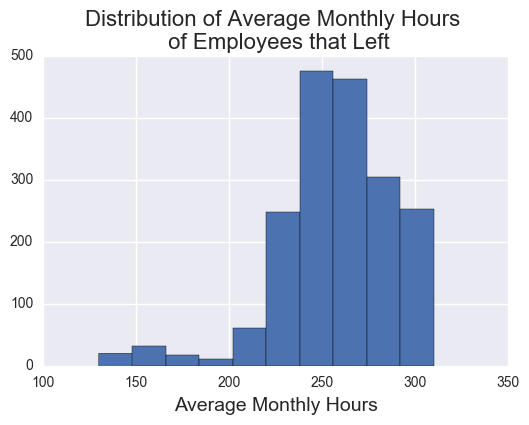

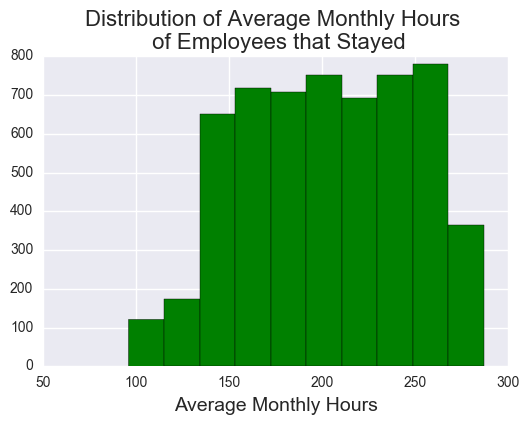

Avg Monthly hours for employees that left: 257.0
Avg Monthly hours for employees that stayed: 203.0


In [699]:
df[(df['last_evaluation']>eval_limit) & (df['left']==1)]['average_monthly_hours'].hist()
plt.title('Distribution of Average Monthly Hours \n of Employees that Left',fontsize=16)
plt.xlabel('Average Monthly Hours',fontsize=14)
plt.show()
df[(df['last_evaluation']>eval_limit) & (df['left']==0)]['average_monthly_hours'].hist(color='green')
plt.title('Distribution of Average Monthly Hours \n of Employees that Stayed',fontsize=16)
plt.xlabel('Average Monthly Hours',fontsize=14)
plt.show()

plt.show()
print 'Avg Monthly hours for employees that left:',df[(df['last_evaluation']>eval_limit) & (df['left']==1)]['average_monthly_hours'].mean().round(0)
print 'Avg Monthly hours for employees that stayed:',df[(df['last_evaluation']>eval_limit) & (df['left']==0)]['average_monthly_hours'].mean().round(0)

Analyzing Salary and whether employee was promoted in the last 5 years, below table shows that 31% of the employees that left had low salary and were not promoted in last 5 years, while 23% left had medium salary and were not promoted in last 5 years. 28 people left that had high salary and were not promoted in the last 5 years. Of the 1893 employees that left, 99.7% left because they were not promoted in last 5 years (while having an evaluation score of 71% and higher)

In [701]:
print df[(df['last_evaluation']>eval_limit)]['average_monthly_hours'].describe()
high_eval = df[(df['last_evaluation']>eval_limit)].copy()
high_eval['hour_bucket'] = high_eval['average_monthly_hours'].apply(lambda x: 1 if x > 200 else 0)
sal_hr = high_eval.groupby(['salary','promotion_last_5years'])['left'].agg([len,sum])
sal_hr['left%'] = (sal_hr['sum'] / sal_hr['len']).round(2)
sal_hr.rename(columns = {'len':'count','sum':'left'},inplace=True)
sal_hr.reset_index(inplace = True)
sal_hr

#almost all the people left regardless of salary due to not being promoted in last 5 years even though evals are high

count    7606.000000
mean      216.385485
std        47.828798
min        96.000000
25%       177.000000
50%       224.000000
75%       255.000000
max       310.000000
Name: average_monthly_hours, dtype: float64


,salary,promotion_last_5years,count,left,left%
0,high,0,560,28,0.05
1,high,1,33,0,0.00
2,low,0,3700,1140,0.31
3,low,1,28,3,0.11
4,medium,0,3193,721,0.23
5,medium,1,92,1,0.01


Satisfaction level is lowest among low/medium employees that have not been promoted and left. They also have spent more time with the company and higher number of projects.

In [678]:
high_eval.groupby(['salary','promotion_last_5years','left'])['satisfaction_level','time_spend_company','number_project'].mean()


satisfaction_level  time_spend_company  \
salary promotion_last_5years left                                           
high   0                     0               0.658571            3.618421   
                             1               0.413571            4.464286   
       1                     0               0.588485            6.090909   
low    0                     0               0.678461            3.254297   
                             1               0.466895            4.587719   
       1                     0               0.699200            3.440000   
                             1               0.110000            4.000000   
medium 0                     0               0.682557            3.436084   
                             1               0.459015            4.563107   
       1                     0               0.714505            3.593407   
                             1               0.870000            5.000000   

                                   number_project  
salary promotion_last_5years left                  
high   0                     0           3.793233  
                             1           5.571429  
       1                     0           3.909091  
low    0                     0           3.843359  
                             1           5.303509  
       1                     0           3.880000  
                             1           6.000000  
medium 0                     0           3.795307  
                             1           5.300971  
       1                     0           4.065934  
                             1           4.000000

In [679]:
df['hour_bucket'] = df['average_monthly_hours'].apply(lambda x: 1 if x>160 else 0)
print 'total number of employees that left:',df['left'].sum()
print 'total number of employees that worked more than 160 hrs, never promoted in last 5 years and low/medium salary'
print df[df['hour_bucket']==1 & (df['promotion_last_5years']==0) &((df['salary']=='low') | (df['salary']=='medium'))]['left'].sum()

print df[df['hour_bucket']==1 & (df['promotion_last_5years']==0) &((df['salary']=='low') | (df['salary']=='medium'))]['left'].value_counts()

df[df['hour_bucket']==1 & (df['promotion_last_5years']==0) &((df['salary']=='low') | (df['salary']=='medium'))].describe()

total number of employees that left: 3571
total number of employees that worked more than 160 hrs, never promoted in last 5 years and low/medium salary
2020
0    7915
1    2020
Name: left, dtype: int64


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left,hour_bucket
count,9935.000000,9935.000000,9935.000000,9935.000000,9935.000000,9935.000000,9935.000000,9935.000000,9935.000000
mean,0.629113,0.748945,4.078208,222.678712,3.561248,0.145949,0.009059,0.203322,0.961751
std,0.261396,0.164007,1.164376,40.060394,1.466713,0.353073,0.094751,0.402490,0.191806
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.610000,3.000000,190.000000,3.000000,0.000000,0.000000,0.000000,1.000000
50%,0.690000,0.770000,4.000000,226.000000,3.000000,0.000000,0.000000,0.000000,1.000000
75%,0.830000,0.890000,5.000000,255.000000,4.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,1.000000


The above speaks volumes. Majority of the employees that were not promoted in the last 5 years (constraining to the evaluation limit), regardless of salary left. A higher percentage left that were paid low or medium salary vs high.
The Satisfaction level for the low salaried employee that were not promoted and left were 0.11. For the medium salaried employee that were not promoted and left was 0.46. The difference between the employees that were not promoted and left was at minimum 20% lower than the ones that were not promoted and stayed. On Average they also had one more project underneath their belt. 

Conclusion would be that while they had high evaluations, the ones that were not promoted and had low/medium salaries left. They could have felt under appreciated. 

### Hypothesis:

Employees that are were not promoted in the last 5 years, regardless of hours worked and salary,are more likely to leave. 

Using only subset of the information (50% where the last evaluation was 0.71 or greater, will predict which of the employees will leave. The subset is 0.75 because we want to figure out why good employees leave versus bad/marginal ones. 

In [680]:
def set_target(eval_limit,df):
    df1 = df[df['last_evaluation'] > eval_limit].copy()
    #df2 = df1[df1['hour_bucket']==1 & (df1['promotion_last_5years']==0) &((df1['salary']=='low') | (df1['salary']=='medium'))]
    temp = []
    for x,y in zip(df1['promotion_last_5years'],df1['left']):
        if (x==0) & (y==1):
            temp.append(1)
        else:
            temp.append(0)
    df1['left_not_promoted'] = temp
            
    return df1

df2 = set_target(0.75,df)
df2.sum()

#left is almost the same as the ones that left and not promoted. this means majority of the people that left were not promoted


satisfaction_level                                                 4133.87
last_evaluation                                                     5888.9
number_project                                                       28373
average_monthly_hours                                              1458392
time_spend_company                                                   24874
Work_accident                                                          923
promotion_last_5years                                                  131
sales                    salessalessalessalessalessalessalessalessaless...
salary                   mediummediumlowlowlowlowlowlowlowlowlowlowlowl...
left                                                                  1869
hour_bucket                                                           5628
left_not_promoted                                                     1865
dtype: object

In [681]:
df2.head(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,left,hour_bucket,left_not_promoted
1,0.80,0.86,5,262,6,0,0,sales,medium,1,1,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1,1,1
3,0.72,0.87,5,223,5,0,0,sales,low,1,1,1
6,0.10,0.77,6,247,4,0,0,sales,low,1,1,1
7,0.92,0.85,5,259,5,0,0,sales,low,1,1,1
8,0.89,1.00,5,224,5,0,0,sales,low,1,1,1
11,0.11,0.81,6,305,4,0,0,sales,low,1,1,1
12,0.84,0.92,4,234,5,0,0,sales,low,1,1,1
17,0.78,0.99,4,255,6,0,0,sales,low,1,1,1
19,0.76,0.89,5,262,5,0,0,sales,low,1,1,1


#### Setting X's and target

In [682]:
y=df2['left']
df2['salary_high'] = df2['salary'].apply(lambda x: 1 if x=='high' else 0)
#df2['salary'] = le.fit_transform(df2['salary'])
df2['sales'] = le.fit_transform(df2['sales'])

cols_to_use = ['satisfaction_level','number_project','average_monthly_hours','time_spend_company']

X = df2[cols_to_use]
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=25)

In [683]:
print 'High Salaried Employees that left Avg Monthly Hours:',df2[(df2['left']==1) & (df2['salary_high']==1)]['average_monthly_hours'].mean()
print 'High Salaried Employees Avg Monthly Hours:',df2[(df2['salary_high']==1)]['average_monthly_hours'].mean()
print 'A difference of 57 hours per month higher for the ones that left, left due to being overworked'
df2[(df2['left']==1) & (df2['salary_high']==1)].head()


High Salaried Employees that left Avg Monthly Hours: 267.857142857
High Salaried Employees Avg Monthly Hours: 210.987903226
A difference of 57 hours per month higher for the ones that left, left due to being overworked


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,left,hour_bucket,left_not_promoted,salary_high
111,0.09,0.85,6,289,4,0,0,3,high,1,1,1,1
345,0.10,0.86,6,278,4,0,0,9,high,1,1,1,1
696,0.10,0.81,7,291,4,0,0,7,high,1,1,1,1
735,0.83,0.99,5,258,5,0,0,8,high,1,1,1,1
852,0.82,0.89,5,217,5,0,0,7,high,1,1,1,1


#### Random Forest Model

In [654]:
rf = RandomForestClassifier(random_state=80)
rf = rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
print 'Accuracy Score:',accuracy_score(y_test,rf_pred)
print "F1 Score is:",f1_score(y_test,rf_pred)
print "Precision Score is:",precision_score(y_test,rf_pred)
print "Recall Score is:",recall_score(y_test,rf_pred)
print classification_report(y_test,rf_pred)
pd.DataFrame(confusion_matrix(y_test,rf_pred),index=['stayed','left'],columns = ['pred_stayed','pred_left'])

Accuracy Score: 0.985928279619
F1 Score is: 0.974145120934
Precision Score is: 0.979865771812
Recall Score is: 0.968490878939
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1600
          1       0.98      0.97      0.97       603

avg / total       0.99      0.99      0.99      2203



,pred_stayed,pred_left
stayed,1588,12
left,19,584


In [655]:
pd.concat([pd.Series(X.columns,name='Features'),pd.Series(rf.feature_importances_,name='Feature Importance')],axis=1)

,Features,Feature Importance
0,satisfaction_level,0.361530
1,number_project,0.117050
2,average_monthly_hours,0.168436
3,time_spend_company,0.352984


In [626]:
y_test.reset_index(inplace=True,drop=True)
rf_y = pd.concat([pd.Series(y_test),pd.Series(rf_pred,name='pred')],axis=1)
rf_y = pd.concat([rf_y,pd.DataFrame(rf.predict_proba(X_test))],axis=1)
rf_y['diff'] = rf_y['left'] - rf_y['pred']
rf_y['diff'] = rf_y['diff'].apply(lambda x: 1 if x !=0 else 0)
X_test.reset_index(inplace = True, drop=True)
combined = pd.concat([X_test,rf_y],axis=1)
combined[combined['diff']==1]

,satisfaction_level,number_project,average_monthly_hours,time_spend_company,left,pred,0,1,diff
124,0.34,6,157,5,1,0,1.0,0.0,1
257,0.09,3,214,2,1,0,0.5,0.5,1
378,0.19,4,192,4,1,0,0.6,0.4,1
419,0.66,5,269,5,1,0,0.7,0.3,1
572,0.57,4,219,2,1,0,1.0,0.0,1
576,0.81,2,156,5,0,1,0.3,0.7,1
628,0.30,5,257,5,1,0,1.0,0.0,1
666,0.90,4,254,7,0,1,0.4,0.6,1
696,0.90,4,279,6,0,1,0.0,1.0,1
795,0.90,4,254,7,0,1,0.4,0.6,1


Possible errors would be the ones that retired or found higher paying jobs.
Thus it boils down to not being promoted in the last 5 years or being over-worked (too many hours)

#### Extra Trees

In [656]:
et = ExtraTreesClassifier(random_state=80)
et = et.fit(X_train,y_train)
et_pred = et.predict(X_test)
print 'Accuracy Score:',accuracy_score(y_test,et_pred)
print "F1 Score is:",f1_score(y_test,et_pred)
print "Precision Score is:",precision_score(y_test,et_pred)
print "Recall Score is:",recall_score(y_test,et_pred)
print classification_report(y_test,et_pred)
pd.DataFrame(confusion_matrix(y_test,et_pred),index=['stayed','left'],columns = ['pred_stayed','pred_left'])

Accuracy Score: 0.984566500227
F1 Score is: 0.971760797342
Precision Score is: 0.973377703827
Recall Score is: 0.970149253731
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1600
          1       0.97      0.97      0.97       603

avg / total       0.98      0.98      0.98      2203



,pred_stayed,pred_left
stayed,1584,16
left,18,585


In [704]:
pd.concat([pd.Series(X.columns,name='Features'),pd.Series(et.feature_importances_,name='Feature Importance')],axis=1)

,Features,Feature Importance
0,satisfaction_level,0.315622
1,number_project,0.195644
2,average_monthly_hours,0.197809
3,time_spend_company,0.290925


#### Gradient Boosting

In [ ]:
from sklearn.preprocessing import RobustScaler

X2 = pd.DataFrame(RobustScaler().fit_transform(X),columns=X.columns)
X2_train,X2_test, y_train,y_test = train_test_split(X2,y,test_size=0.33,random_state=25)

In [716]:
gb = GradientBoostingClassifier(n_estimators = 1000)
gb = gb.fit(X2_train,y_train)
gb_pred = gb.predict(X2_test)
print 'Accuracy Score:',accuracy_score(y_test,gb_pred)
print "F1 Score is:",f1_score(y_test,gb_pred)
print "Precision Score is:",precision_score(y_test,gb_pred)
print "Recall Score is:",recall_score(y_test,gb_pred)
print classification_report(y_test,gb_pred)
pd.DataFrame(confusion_matrix(y_test,gb_pred),index=['stayed','left'],columns = ['pred_stayed','pred_left'])

Accuracy Score: 0.980935088516
F1 Score is: 0.965460526316
Precision Score is: 0.957585644372
Recall Score is: 0.973466003317
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      1600
          1       0.96      0.97      0.97       603

avg / total       0.98      0.98      0.98      2203



,pred_stayed,pred_left
stayed,1574,26
left,16,587


### ROC for Random Forest Model

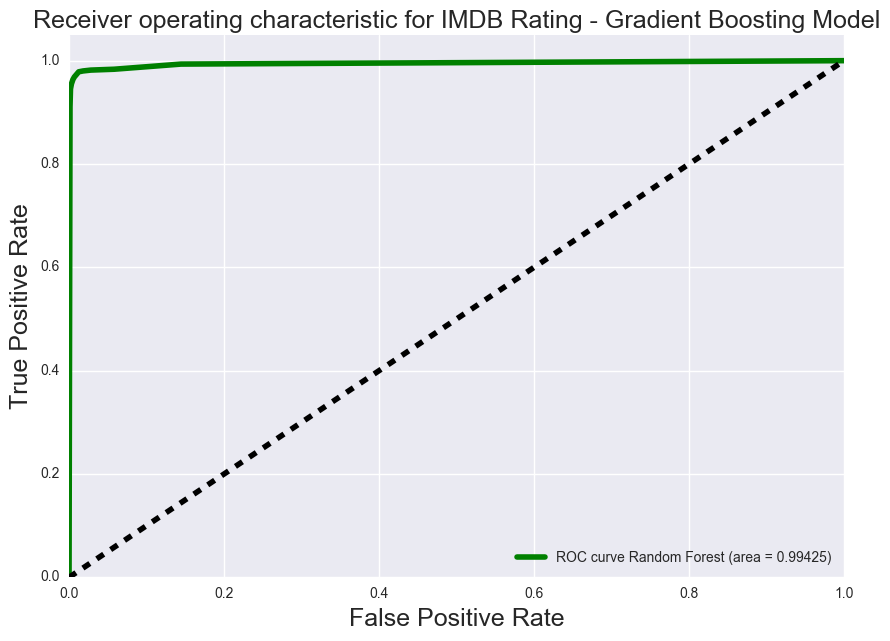

In [621]:

y_pp_rf = pd.DataFrame(rf.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
y_pp_et = pd.DataFrame(et.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
FPR_rf = dict()
TPR_rf = dict()
ROC_AUC_rf = dict()

FPR_et = dict()
TPR_et = dict()
ROC_AUC_et = dict()


# For class 1, find the area under the curve

FPR_rf[1], TPR_rf[1], _ = roc_curve(y_test,y_pp_rf['class_1_pp'])
FPR_et[1], TPR_et[1], _ = roc_curve(y_test,y_pp_et['class_1_pp'])

ROC_AUC_rf[1] = auc(FPR_rf[1],TPR_rf[1])
ROC_AUC_et[1] = auc(FPR_et[1],TPR_et[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[10,7])

plt.plot(FPR_rf[1], TPR_rf[1],label='ROC curve Random Forest (area = %0.5f)' % ROC_AUC_rf[1], linewidth=4, color = 'green')
#plt.plot(FPR_et[1], TPR_et[1],label='ROC curve Gradient Boosting (area = %0.5f)' % ROC_AUC_rf[1], linewidth=4, color = 'blue')

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for IMDB Rating - Gradient Boosting Model', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Conclusion

The bulk of employees that had a low evaluation (0.55 and under) ended up leaving. The amount of employees that had a evaluation score of 0.50 or lower were less than 25% of all employees. Since we do not care about employees with poor performance leaving compared to the ones that had a high evaluation score leaving, the analysis looked at the latter.

The bulk of employees that scored high evaluation left primarily due to not being promoted in the last 5 years. Majority of these salaries were categorized as low/medium. Furthermore, this was heavily skewed if the employee worked more than 200 hours. 

Thus, if an employee has a high evaluation (above 0.70) and especially a low/medium salary, it would be advisable to promote the employee especially if the employee works more than 200 hours. 


There is really no need for running a machine learning algorithm as the accuracy for Random Forest, Extra Trees, and Gradient Boosting are upper 90%. Random Forest had the highest accuracy, while Gradient Boosting had the lowest Type II error, which that would be the employees that were predicted to stay, but left. Some possible errors could be retirement, found higher paying jobs, or a better work-life balance. 